# Predictor Evaluation and Visualization

---- Add explanation ----

## Notes and todos:
- 

In [ ]:
import os
os.chdir('/app/Pogona_realtime/Arena')

## Imports

In [2]:
import numpy as np
import pandas as pd
import pickle
import imp
import json
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Button
import seaborn as sns
#from tqdm.auto import tqdm
from tqdm import tqdm
import torch
import glob
from datetime import datetime
import cv2 as cv
from scipy.stats import pearsonr


from Prediction import dataset
from Prediction import train_eval
from Prediction import predictor
from Prediction import visualize
from Prediction import detector
from Prediction import kalman_predict
from Prediction import seq2seq_predict
from Prediction import calibration as calib
from Prediction import traj_models

In [3]:
imp.reload(dataset)
imp.reload(train_eval)
imp.reload(seq2seq_predict)
imp.reload(predictor)
imp.reload(visualize)
imp.reload(detector)
imp.reload(dataset)
imp.reload(kalman_predict)
imp.reload(traj_models)

<module 'Prediction.traj_models' from '/app/Pogona_realtime/Arena/Prediction/traj_models.py'>

In [118]:
(mapx, mapy), roi, ncmtx = calib.get_undistort_mapping(100,100)

In [122]:
ncmtx

array([[-419.92816162,    0.        , -260.01230545],
       [   0.        , -138.1812439 ,  -63.75685919],
       [   0.        ,    0.        ,    1.        ]])

## Load data

In [4]:
all_df = dataset.collect_data(data_sources={'detections': True, 'timestamps': True, 'dlc': False, 'touches': True})

110 trials loaded


In [5]:
trials = all_df.index.unique()

## Load Trajectory Predictors

In [6]:
model_names = ['RNN_GRU_1013-1951_i20_o20_h350_l1','Linear_GRU_1013-1345_i20_o20_h350_l3']

In [7]:
seq2seq_models = []
for model_name in model_names:
    net, model_params = traj_models.get_model(model_name)
    traj_predictor = seq2seq_predict.Seq2SeqPredictor(model=net, 
                                                      weights_path=traj_models.get_weights_path(model_name),
                                                      input_len=model_params['network_params']['inp_seq_len'],
                                                      forecast_horizon=model_params['network_params']['out_seq_len'])
    traj_predictor.model_params = model_params
    seq2seq_models.append(traj_predictor)

In [124]:
# Kalman Trajectory Predictor
kalman_predictor = kalman_predict.KalmanPredictor(forecast_horizon=20, 
                                                num_derivatives=1, 
                                                q_var=2.145, r_var=120.0)

In [125]:
# Kalman Trajectory Predictor with constant acceleration
kalman_predictor_acc = kalman_predict.KalmanPredictor(forecast_horizon=20, 
                                                      num_derivatives=2, 
                                                      q_var=6.6, r_var=1000)

## Predictor timings

In [9]:
def seq2seq_name(traj_pred):
    inp_len = traj_pred.model_params['network_params']['inp_seq_len']
    out_len = traj_pred.model_params['network_params']['out_seq_len']
    decoder_type = traj_pred.model_params['network_params']['decoder_type']
    rnn_type = traj_pred.model_params['network_params']['rnn_type']
    rnn_layers = traj_pred.model_params['network_params']['rnn_layers']
    hidden_size = traj_pred.model_params['network_params']['hidden_size']
    return f'Dec:{decoder_type}, RNN:{rnn_type}, l:{rnn_layers}, h:{hidden_size}, {inp_len}-{out_len}'

In [10]:
K = 5000

rand_bboxes = np.random.random((K, 4))

timings = []
for traj_pred in seq2seq_models + [kalman_predictor]:
    results, _ = train_eval.eval_trajectory_predictor(traj_pred, rand_bboxes, show_progress=False)
    times_arr = np.array(results['times'])
    timings.append(times_arr)

      

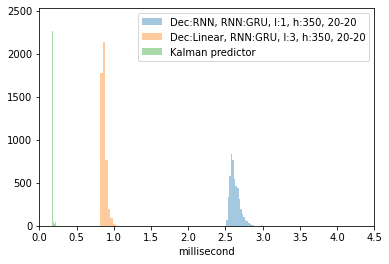

In [11]:
thresh = 0.005
bins = 30

for traj_pred, times in zip(seq2seq_models + [kalman_predictor], timings):
    if traj_pred == kalman_predictor:
        label = "Kalman predictor"
    else:
        label = seq2seq_name(traj_pred)
    sns.distplot(times[times < thresh]*1000, bins=bins, kde=False, label=label)

plt.legend()
plt.xticks(np.arange(0, 5, 0.5))
plt.xlabel('millisecond')
#plt.ylim((0, 1500))
plt.savefig('../experiments_plots/all_timings.png', dpi=200)

## Sequences data

### Custom masking

In [12]:
INF_P = 9999999

mask_dict_alt = {
    'fl_dist': [0, INF_P, True, True], # min, max, mask_X, mask_Y
    'speed': [8, INF_P, True, True],
    'std': [0.0, INF_P, [0,1]],
    'corr': [0.0, 1.0, True, True],
    'zgzg': [0, 1.5, True, True],
    'keep_prob': 0.0
}

In [13]:
# use custom masking dict
mask_dict = mask_dict_alt

In [20]:
# use masking dict that model was trained on
mask_dict = seq2seq_models[0].model_params['masking_params']

In [14]:
mask_fn = train_eval.compose_masks(mask_fns=[
    train_eval.mask_fl_dist(*mask_dict['fl_dist']),
    train_eval.mask_speed(*mask_dict['speed']),
    train_eval.mask_std(*mask_dict['std']),
    train_eval.mask_corr(*mask_dict['corr']),
    train_eval.mask_zgzg(*mask_dict['zgzg'])
    ], invert=False)

### Create trials dict
--- add explanation why trials dict is needed, remind again that it's not scalable ---

In [15]:
# run only in initailization of notebook
net_params = seq2seq_models[0].model_params['network_params']
trials_dict = train_eval.create_samples(df=all_df,
                                        mask_fn=mask_fn,
                                        keep_prob=mask_dict['keep_prob'],
                                        input_labels=net_params['input_labels'], output_labels=net_params['output_labels'], 
                                        input_seq_size=net_params['inp_seq_len'], output_seq_size=net_params['out_seq_len'],
                                        keep_nans=True)

/app/Pogona_realtime/Arena/Prediction/train_eval.py:745: RuntimeWarning: invalid value encountered in greater
  ret_mask = ret_mask & ((dists_X > min_dist) & (dists_X < max_dist))
/app/Pogona_realtime/Arena/Prediction/train_eval.py:745: RuntimeWarning: invalid value encountered in less
  ret_mask = ret_mask & ((dists_X > min_dist) & (dists_X < max_dist))
/app/Pogona_realtime/Arena/Prediction/train_eval.py:747: RuntimeWarning: invalid value encountered in greater
  ret_mask = ret_mask & ((dists_Y > min_dist) & (dists_Y < max_dist))
/app/Pogona_realtime/Arena/Prediction/train_eval.py:747: RuntimeWarning: invalid value encountered in less
  ret_mask = ret_mask & ((dists_Y > min_dist) & (dists_Y < max_dist))
/app/Pogona_realtime/Arena/Prediction/train_eval.py:766: RuntimeWarning: invalid value encountered in greater
  ret_mask = ret_mask & ((speeds_X > min_speed) & (speeds_X < max_speed))
/app/Pogona_realtime/Arena/Prediction/train_eval.py:766: RuntimeWarning: invalid value encountered in 

In [677]:
# run when masking is updated
train_eval.update_trials_dict(trials_dict, mask_fn, keep_prob=mask_dict['keep_prob'])

In [283]:
# create new split of the trials
train_trials, val_trials, test_trials = train_eval.split_train_val_test(trials_dict, split=(1.0, 0, 0))

In [16]:
# use existing split from the model
train_trials = seq2seq_models[0].model_params['training_params']['train_trials']
val_trials = seq2seq_models[0].model_params['training_params']['val_trials']
test_trials = seq2seq_models[0].model_params['training_params']['test_trials']

In [17]:
# create datalaoders for batch inference
batch_size = 128
train_dl, val_dl, test_dl = train_eval.create_train_val_test_dataloaders(trials_dict, train_trials, val_trials, test_trials,
                                                                         train_mask=False, val_mask=False, test_mask=False,
                                                                         batch_size=batch_size, shuffle=False)

print("Sample size:")
print(f"Training: {len(train_trials)} trials, {len(train_dl.dataset)} seqs")
if val_dl is not None:
    print(f"Validation: {len(val_trials)} trials, {len(val_dl.dataset)} seqs")
if test_dl is not None:
    print(f"Test: {len(test_trials)} trials, {len(test_dl.dataset)} seqs")

Sample size:
Training: 88 trials, 381108 seqs
Validation: 11 trials, 54082 seqs
Test: 11 trials, 44491 seqs


### Generate data tensors and predictions

In [18]:
# create numpy 3d-arrays of the data
dl = test_dl
seq_data_X = dl.dataset.X.numpy()
seq_data_Y = dl.dataset.Y.numpy()

In [19]:
print(f'Total MB of data: {seq_data_X.nbytes/2**20 + seq_data_Y.nbytes/2**20:.1f}')

Total MB of data: 27.2


In [20]:
seq_preds = []
for traj_pred in seq2seq_models:
    seq_preds.append(train_eval.get_seq_forecast(dl, traj_pred.model))

In [21]:
ADEs, FDEs, trial_lens, all_forecasts = train_eval.eval_traj_predictor_on_trials(test_trials, kalman_predictor, all_df)
seq_pred_kalman = train_eval.all_forecasts_to_seq_data(all_forecasts, inp_seq_len=net_params['inp_seq_len'], 
                                                            out_seq_len=net_params['out_seq_len'],
                                                            out_dim=net_params['output_dim'])

In [126]:
ADEs, FDEs, trial_lens, all_forecasts = train_eval.eval_traj_predictor_on_trials(test_trials, kalman_predictor_acc, all_df)
seq_pred_kalman_acc = train_eval.all_forecasts_to_seq_data(all_forecasts, inp_seq_len=net_params['inp_seq_len'], 
                                                            out_seq_len=net_params['out_seq_len'],
                                                            out_dim=net_params['output_dim'])

### Average ADE results on test set
- lstm: 9.8143/41.3148
- gru-20: 9.4457/40.2263
- gru-10: 6.4983/22.9242
- kalman 53.77565355787182 / 13.338808356545009


In [129]:
bar_df = pd.DataFrame()
mask = mask_fn(seq_data_X, seq_data_Y)
nan_mask_Y = ~np.isnan(seq_data_Y).any(axis=2).any(axis=1)
nan_mask_X = ~np.isnan(seq_data_X).any(axis=2).any(axis=1)
nan_mask = nan_mask_Y & nan_mask_X
for seq_pred, traj_pred in zip(seq_preds + [seq_pred_kalman, seq_pred_kalman_acc], seq2seq_models + [kalman_predictor, kalman_predictor_acc]):
    ADE = train_eval.calc_ADE(torch.from_numpy(seq_pred[nan_mask]), torch.from_numpy(seq_data_Y[nan_mask]))
    masked_ADE = train_eval.calc_ADE(torch.from_numpy(seq_pred[mask]), torch.from_numpy(seq_data_Y[mask]))
    
    if traj_pred == kalman_predictor:
        name = 'Kalman'
    elif traj_pred == kalman_predictor_acc:
        name = 'Kalman acceleration' 
    else:
        name = seq2seq_name(traj_pred)
    
    bar_df.loc[name, 'False'] = ADE.item()
    bar_df.loc[name, 'True'] = masked_ADE.item()


In [130]:
bar_df['Model'] = bar_df.index

long_df = pd.melt(bar_df,id_vars=['Model'], var_name='Masking',value_name='ADE', ignore_index=False)

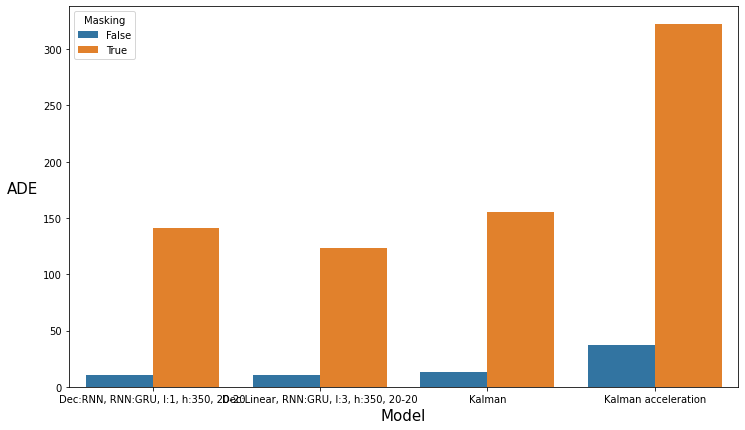

In [131]:
%matplotlib inline
plt.figure(figsize=(12,7))
sns.barplot(x='Model',y='ADE',hue='Masking',data=long_df)
plt.ylabel('ADE',fontsize=15, rotation=0,labelpad=20)
plt.xlabel('Model',fontsize=15)

plt.savefig('../experiments_plots/ADEs_bar.jpg',dpi=200)

### Visualize sequences and predictions

In [36]:
%matplotlib widget
#%matplotlib inline
fig,ax = plt.subplots(1,1,figsize=(10,16))

im = cv.imread('../pogona_frames/transformed_image.jpg')
im = cv.convertScaleAbs(im, alpha=2.5,beta=-128)
ax.imshow(im,alpha=0.15)

colors = plt.get_cmap('tab10').colors[:2] + plt.get_cmap('tab10').colors[4:] 

N_samples = 5

data_mask = mask_fn(seq_data_X, seq_data_Y)
sampling_mask = np.random.choice(np.argwhere(data_mask).squeeze(), size=N_samples)

sample_X = seq_data_X[sampling_mask]
sample_Y = seq_data_Y[sampling_mask]

l_alpha = 0.5

visualize.draw_sequences(arr_X=sample_X,
           arr_Y=sample_Y,
           arr_pred=None,
           ax=ax,
           sctr_s=1,
           l_alpha=l_alpha,
           sctr_alpha=0.75,
           draw_diffs=False)

for i, (seq_pred, traj_pred) in enumerate(zip(seq_preds + [seq_pred_kalman], 
                                               seq2seq_models + [kalman_predictor])):
    
    if traj_pred == kalman_predictor:
        name = 'Kalman'
    else:
        name = seq2seq_name(traj_pred)
        
    sample_pred = seq_pred[sampling_mask]
    
    visualize.draw_sequences(arr_X=None,
                   arr_Y=sample_pred,
                   arr_pred=None,
                   ax=ax,
                   sctr_s=1,
                   l_alpha=l_alpha,
                   sctr_alpha=0.75,
                   draw_diffs=False,
                   ylabel=name,
                   ftr_c=colors[i % len(colors)]
                  )


#ax.axis('equal')
#txt_color = 'white'
ax.set_title(f'Input: {net_params["inp_seq_len"]}, Output: {net_params["out_seq_len"]} || {data_mask.sum():,} sequences',fontsize=13)
fig.set_facecolor(color='w')
ax.legend()

#plt.savefig("../experiments_plots/sequence_sample.png", dpi=200)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

## Sequence data stats

In [66]:
def plot_distribution(ax, 
                   data_array,
                   label,
                   min_thresh=None, max_thresh=None,
                   title=None,
                   kde=True, bins=500, color='b',
                   quantiles=[0.1, 0.25, 0.5, 0.75]):
    
    mask = np.array([True] * data_array.shape[0])
    if min_thresh:
        min_mask = data_array > min_thresh
        mask = mask & min_mask
    if max_thresh:
        max_mask = data_array < max_thresh
        mask = mask & max_mask     
        
    sns.distplot(data_array[mask], label=label, kde=kde, bins=bins,ax=ax, color=color)
    ax.set_xlabel(label, fontsize=16, labelpad=5)
    
    if quantiles is not None:
        bins, vals = np.histogram(data_array[mask], bins=bins)
        top = np.max(bins)
        for q in quantiles:
            quan_val = np.quantile(data_array[mask].dropna(), q)
            ax.plot(np.ones(2) * quan_val, [0,top-top//50], linestyle='--', color='r', linewidth=1, alpha=0.5)
            ax.text(quan_val, top, q, fontsize=10, rotation=0, color='r')
                
    
    #ax.legend()
    if title:
        ax.set_title(title)


In [67]:
#funcs = [train_eval.compute_dists, train_eval.compute_speeds, train_eval.compute_zigzagity, train_eval.compute_batch_r]
funcs = [train_eval.compute_speeds, train_eval.compute_zigzagity, train_eval.compute_batch_r]

#labels = ['distance', 'speed','zigzagity', 'pear_r']
labels = ['speed','zigzagity', 'pear_r']

distr_X_full = {key:pd.Series(func(seq_data_X), name=key) for key,func in zip(labels, funcs)}

In [68]:
funcs = [train_eval.compute_dists, train_eval.compute_speeds, train_eval.compute_zigzagity, train_eval.compute_batch_r]
labels = ['distance', 'speed','zigzagity', 'pear_r']
distr_X_hits = {key:pd.Series(func(hits_X[:,:,2:]),name=key) for key,func in zip(labels, funcs)}

In [345]:
from sklearn.mixture import GaussianMixture
em = GaussianMixture(n_components=2)
x = distr_X_full['zigzagity'].values
x = x[~np.isnan(x)]
em.fit(x.reshape(-1,1))

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
        means_init=None, n_components=2, n_init=1, precisions_init=None,
        random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)

In [346]:
em.covariances_, em.means_

(array([[[0.02123716]],
 
        [[0.13619551]]]),
 array([[2.06805665],
        [1.47130749]]))

In [334]:
s = np.random.normal(loc=2.06, scale=0.02**0.5, size=1000)

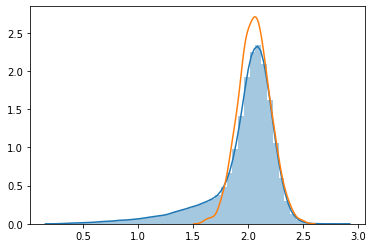

In [342]:
sns.distplot(x, bins=50)
sns.distplot(s, bins=50, hist=False)

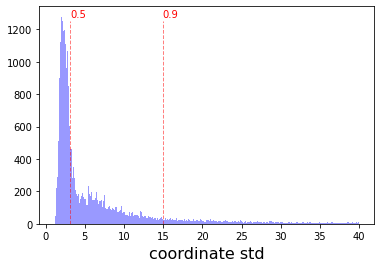

In [93]:
std = np.sqrt(train_eval.compute_var(seq_data_X, seq_data_Y))
dist_std = pd.Series(std, name="std").dropna()
fix, ax = plt.subplots()
plot_distribution(ax, dist_std, "coordinate std", quantiles=[0.5, 0.9], kde=False, min_thresh=0, max_thresh=40)

In [95]:
np.quantile(dist_std, 0.5)

3.341465950012207

In [583]:
np.quantile(distr_X_full['zigzagity'].dropna(),0.025)

1.0672481656074524

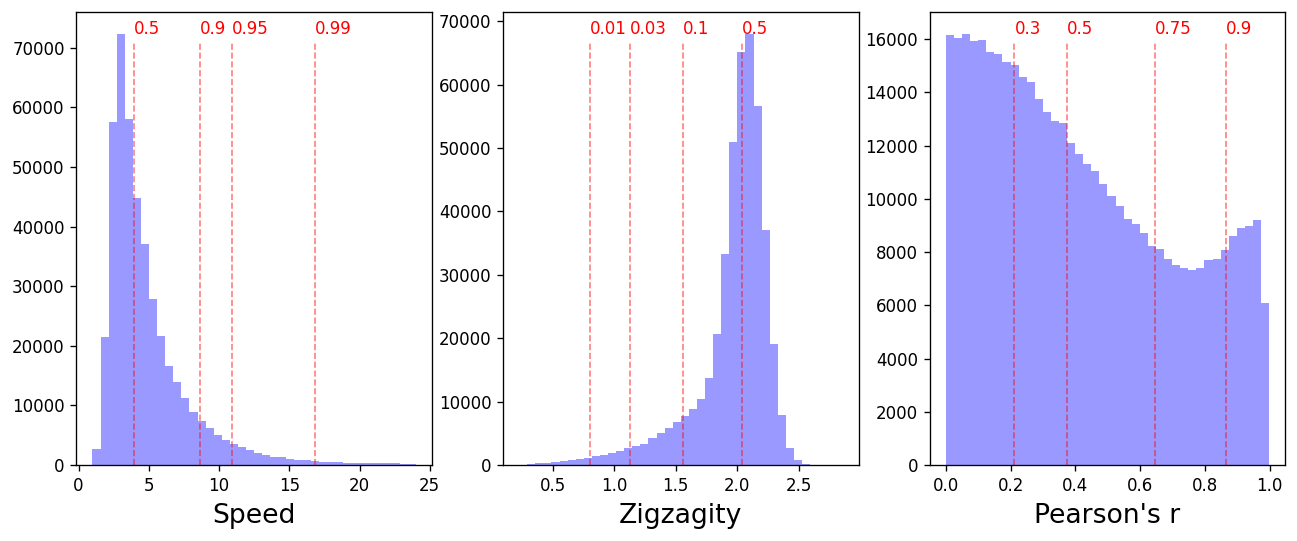

In [579]:
%matplotlib inline
preety_labels = {'speed': 'Speed', 'zigzagity':'Zigzagity', 'pear_r':"Pearson's r"}
labels_quantiles = {'speed': [0.5, 0.9, 0.95, 0.99], 
                    'zigzagity':[0.01, 0.03, 0.10, 0.5], 
                    'pear_r': [0.3, 0.5, 0.75, 0.9]}

fig, axes = plt.subplots(1, len(funcs), figsize=(13,5), dpi=120)
for ax, label in zip(axes, labels):
    max_thresh = 24
    plot_distribution(ax, 
                      distr_X_full[label], 
                      label=preety_labels[label],
                      kde=False,
                      bins=40, max_thresh=max_thresh, quantiles=labels_quantiles[label])
    """
    plot_distribution(ax, 
                      distr_X_full[label], 
                      label=None,
                      kde=True,
                      bins=50, color='r',max_thresh=max_thresh)
    """
#fig.suptitle('Data statitstics', fontsize=20)
#fig.tight_layout()
fig.savefig('../experiments_plots/data_stats.jpg',dpi=120)


In [42]:
model_params['masking_params']

{'fl_dist': [0, 9999999, True, True],
 'speed': [0, 9999999, True, True],
 'std': [0.0, 9999999, [0, 1]],
 'corr': [0.0, 1.0, True, True],
 'zgzg': [0, 1.5, True, True],
 'keep_prob': 0.01}

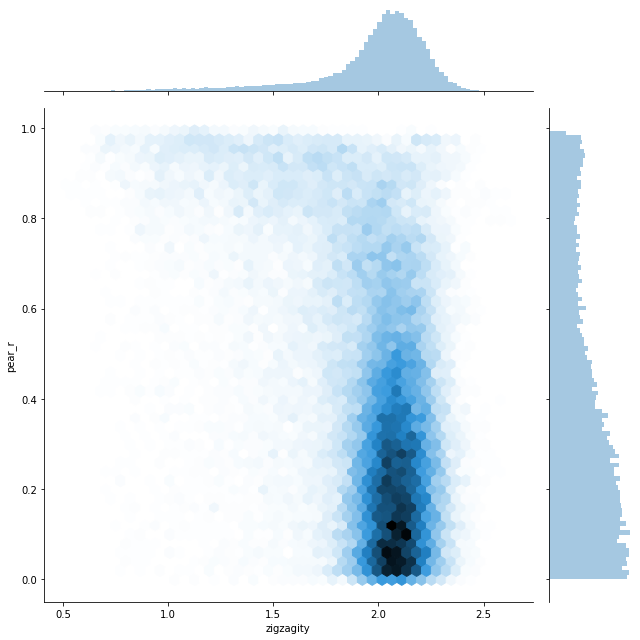

In [198]:
%matplotlib inline
# plot 2d relationship
x_axis = 'zigzagity'
y_axis = 'pear_r'
alpha = 1
color='r'

#plt.figure()
#fig, ax = plt.subplots(1,1,figsize=(12,6))
#sns.scatterplot(distr_X_full[x_axis], distr_X_full[y_axis], ax=ax, alpha=alpha,color=color)
g = sns.jointplot(distr_X_full[x_axis], distr_X_full[y_axis], kind='hex',alpha=alpha,marginal_kws={'bins':100}, height=9)
#fig.set_facecolor('w')
g.savefig('../experiments_plots/zgzg_r_data.jpg')

## Evaluate Hit Predictor

### Hit predictor notes
TODO<br>
Maybe other visualiztions that combine the temporal data with the arena coordinates data.

Metrics - TODO:<br>
We can compare that structure to the real frames that have an actual hit event and their respective x values,
and calculate various metrics that quantify the errors. Join the the arrays.
FN - missed an hit event (by how much?)
FP - predicted an hit event by mistake (relative to what ground truth events?)
Other issues: how to decide what is a "close" event? what to do if there are many? etc...


### Hit predictor functions

In [50]:
# find start and end indices for each test trial in sequence arrays

trials_slicing = dict()
ind = 0
for trial in test_trials:
    trial_inds = np.argwhere(all_df.index == trial)
    start = trial_inds[0 + net_params['inp_seq_len'] - 1][0]
    end = trial_inds[-net_params['out_seq_len']][0]
    
    trial_len = end - start
    
    trials_slicing[trial] = (ind, ind + trial_len)
    ind += trial_len

In [386]:
hit_trials = ['learning_20200917T152238_trial1', 'fast_cockroach_20200803T085738_trial1',
             'learning_20201001T084647_trial1', 'fast_line_20200803T082414_trial1', 'line_20200803T081429_trial1']
hit_df = all_df.loc[hit_trials]

In [387]:
lots_o_touches = 'circle_20200803T115839_trial1'
lots_o_touches2 = 'fast_cockroach_20200803T085738_trial1'

In [47]:
# TODO: aligning with true touching events won't work, check FIRST_FRAME parameter from evaluate trajectory predictor cell

def get_hit_preds_forecasts(seq_pred_trial, 
                            hit_pred,
                            inp_len,
                            return_mean=False):
    """
    Receive an array of forecasts, and generate an array describing the hit predictions from the frame perspective,
    i.e, for each frame, there's a row of length forecast_horizon, with a value in the index of a forecast that 
    predicted a hit. (if forecast 1234 predicted hit in 5 frames, then pred[1239,5] has a value).
        
    If return_mean is true, will count the number of forecasts predicting a hit for a specific frame, and the mean predicted
    x value.
    """
    if np.all(np.isnan(seq_pred_trial)):
        print("No forecasts in list")
        return
    
    forecast_horizon = seq_pred_trial.shape[1]
    preds = np.empty((seq_pred_trial.shape[0] + forecast_horizon, forecast_horizon))    
    preds[:] = np.nan
    
    for i, forecast in enumerate(seq_pred_trial):
        x, hit_ind = hit_pred.predict_hit(forecast)
        if hit_ind is not None and hit_ind < preds.shape[0]:
            frame_ind = inp_len - 1 + (i+1) + hit_ind #  the frame index to which the hit is predicted
            preds[frame_ind, hit_ind] = x  # place the x value in the index that the forecast predicted

    
    if return_mean:
        temp = np.empty((preds.shape[0], 2))
        temp[:,0] = (~np.isnan(preds)).sum(axis=1) # number of forecasts predicting hit
        temp[:, 1] = np.nanmean(preds,axis=1)
        return temp
    return preds


def plot_preds_and_truth(preds, 
                         trial_slice, 
                         ax,
                         start=None, 
                         end=None,):
    """
    preds - a frame prediction array
    trial_slice - the slice from the dataframe for that trial, sliced like the bboxes array
    which the traj predictor operated on.
    Caller's responsibility to make sure the arrays are the same shape on dim 0 and that 
    they are aligned.
    """
    
    hits = False
    
    if start is None:
        start = 0
    if end is None:
        end = preds.shape[0]
    
    ax.set_xticklabels(np.arange(start=start, stop=end+1)) # ax.set_xticks set the integer indices of the labels
    
    preds = preds[start:end]
    trial_slice = trial_slice.iloc[start:end]
    
    forecast_horizon = preds.shape[1]
    if trial_slice is not None:
        hits_idx = np.where(trial_slice.is_touch)[0]
    
        if hits_idx.shape[0] == 0:
            print("no real hits")
        else:
            hits = True
    
    if np.all(np.isnan(preds)):
        print("All nan, nothing to show")
        return
    sns.heatmap(preds.transpose(), ax=ax, cmap='winter')
        
    curr_x_ticks = list(ax.xaxis.get_ticklabels())
    stride = int(curr_x_ticks[1].get_text())
    ax.set_xticklabels(np.arange(start=start, stop=end+1,step=stride), rotation=30) # ax.set_xticks set the integer indices of the labels
    tick_freq = 3
    for n, label in enumerate(ax.xaxis.get_ticklabels()):
        if n % tick_freq != 0:
            label.set_visible(False)
        
    if hits:
        for x in hits_idx:
            ax.plot(np.ones(2)*x, np.linspace(0,20,num=2), linestyle='--',linewidth=1.5, color='r', zorder=-1, alpha=0.5) 
    
   

### Hit predictions raster plot

In [61]:
test_trials

['learning_20200917T152238_trial1',
 'learning_20200917T152238_trial3',
 'fast_cockroach_20200803T085738_trial1',
 'learning_20201001T081837_trial3',
 'learning_20201001T081837_trial5',
 'learning_20200917T154539_trial3',
 'worm_circle_20200830T122241_trial1',
 'beetle_fast_line_20200830T124020_trial1',
 'circle_20200803T093051_trial1',
 'line_20200803T095401_trial1',
 'learning_20200923T111426_trial3']

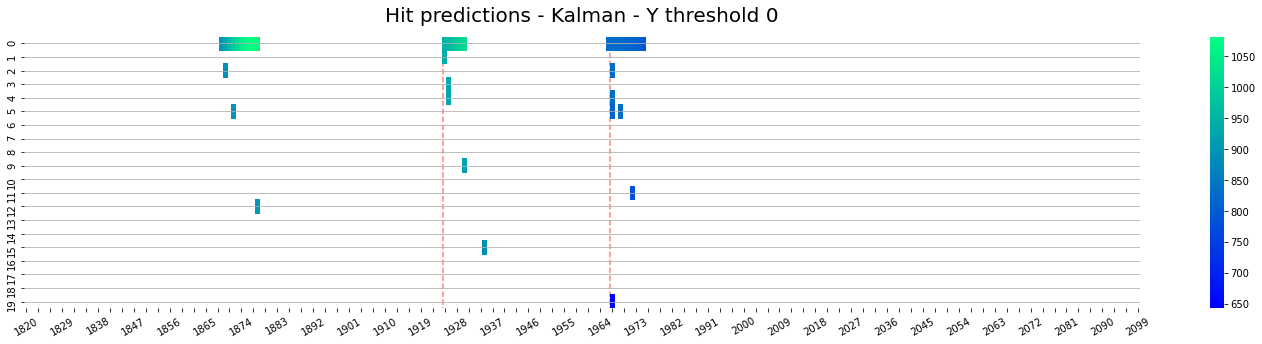

In [117]:
trial = 'fast_cockroach_20200803T085738_trial1'
y_thresh = 0
start = 1820
end = 2100

seq_trial_slice = trials_slicing[trial]
seq_pred_trial = seq_pred_kalman[seq_trial_slice[0]: seq_trial_slice[1]]

hit_preds = get_hit_preds_forecasts(seq_pred_trial=seq_pred_trial,
                                    hit_pred=predictor.HitPredictor(None, prediction_y_threshold=y_thresh),
                                    inp_len=net_params['inp_seq_len'],
                                    return_mean=False)

#%matplotlib widget
%matplotlib inline
fig, ax1 = plt.subplots(1,1,figsize=(25,5))
plot_preds_and_truth(hit_preds,
                     all_df.loc[trial],
                     ax1,
                     start=start,
                     end=end)
plt.grid(axis='y')

s = f"Hit predictions - Kalman - Y threshold {y_thresh}"
plt.title(s, fontsize=fs, pad=pad)
plt.savefig('../experiments_plots/'+trial+"_"+s+'.jpg', dpi=200)

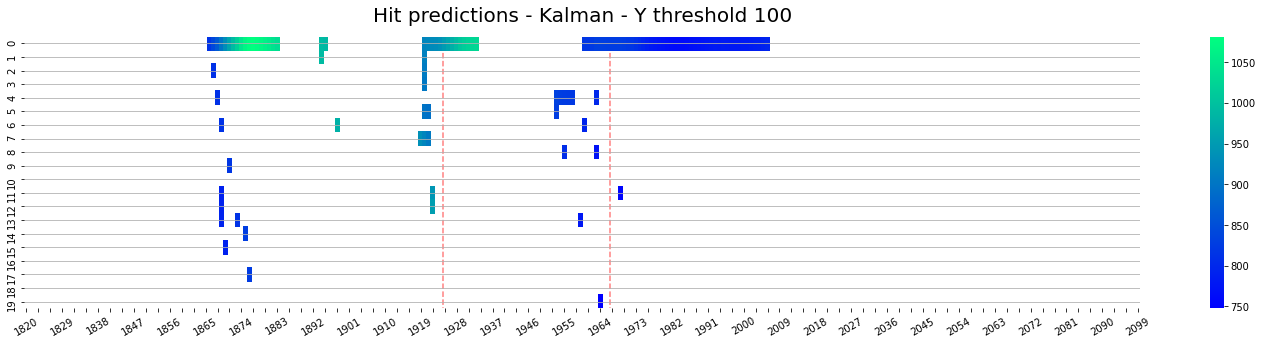

In [113]:
trial = 'fast_cockroach_20200803T085738_trial1'
y_thresh = 100
start = 1820
end = 2100

seq_trial_slice = trials_slicing[trial]
seq_pred_trial = seq_pred_kalman[seq_trial_slice[0]: seq_trial_slice[1]]

hit_preds = get_hit_preds_forecasts(seq_pred_trial=seq_pred_trial,
                                    hit_pred=predictor.HitPredictor(None, prediction_y_threshold=y_thresh),
                                    inp_len=net_params['inp_seq_len'],
                                    return_mean=False)

#%matplotlib widget
%matplotlib inline
fig, ax1 = plt.subplots(1,1,figsize=(25,5))
plot_preds_and_truth(hit_preds,
                     all_df.loc[trial],
                     ax1,
                     start=start,
                     end=end)
plt.grid(axis='y')

s = f"Hit predictions - Kalman - Y threshold {y_thresh}"
plt.title(s, fontsize=fs, pad=pad)
plt.savefig('../experiments_plots/'+trial+"_"+s+'.jpg', dpi=200)

In [111]:
all_df[all_df.is_hit].head()

,cent_x,cent_y,x1,y1,x2,y2,conf,num_bbox,frame_ts,hit_x,hit_y,bug_x,bug_y,is_hit,touch_ts,is_touch
line_20200803T081429_trial1,98.241666,205.037129,210.448093,340.806890,-16.767964,65.175833,0.980696,1.0,2020-08-03 08:14:43.849375963,113.0,691.0,49.0,795.0,True,2020-08-03 08:14:43.845381,True
line_20200803T081429_trial1,-81.487709,172.845578,48.882128,338.830938,-217.203644,-0.040762,0.995821,1.0,2020-08-03 08:15:34.479207754,122.0,322.0,189.0,268.0,True,2020-08-03 08:15:34.485947,True
fast_line_20200803T082414_trial1,-189.002461,1285.678913,-40.956125,1417.212515,-340.842964,1148.696265,0.996272,1.0,2020-08-03 08:24:15.613847494,2028.0,134.0,908.0,570.0,True,2020-08-03 08:24:15.603710,True
fast_line_20200803T082414_trial1,600.031768,126.729824,761.573715,274.951129,436.457676,-28.702548,0.996892,1.0,2020-08-03 08:24:42.118518114,804.0,211.0,766.0,252.0,True,2020-08-03 08:24:42.117620,True
fast_line_20200803T082724_trial1,475.383845,209.210088,581.140541,344.947623,363.492528,68.019484,0.988980,1.0,2020-08-03 08:27:54.528309345,560.0,696.0,636.0,640.0,True,2020-08-03 08:27:54.530850,True


### Displacement Error for each timestep - Maybe

In [ ]:
def calc_mean_DE(y, y_hat):
    """
    Calculate the  average displacement error (DE) of a test set of predictions
    displacement is the L2 norm between the prediction and the truth
    :param y_hat: torch tensor dims (number of sample, out seq size, out size)
    :param y: same
    :return: average DE for each timestep over batch
    """
    if len(y_hat.shape) == 2:
        y_hat = y_hat[None,:,:]
        y = y[None,:,:]

    return np.mean(np.linalg.norm(y_hat - y, axis=2), axis=0)


def calc_DE(y, y_hat):
    """
    Calculate the  average displacement error (DE) of a test set of predictions
    displacement is the L2 norm between the prediction and the truth
    :param y_hat: torch tensor dims (number of sample, out seq size, out size)
    :param y: same
    :return: average DE for each timestep over batch
    """
    if len(y_hat.shape) == 2:
        y_hat = y_hat[None,:,:]
        y = y[None,:,:]

    return np.linalg.norm(y_hat - y, axis=2)


In [ ]:
des = calc_mean_DE(seq_data_Y, seq_data_pred)

In [ ]:
des_dists = calc_DE(seq_data_Y[data_mask], seq_data_pred[data_mask])

In [ ]:
de_df = pd.DataFrame(data=des_dists, columns=np.arange(1,21))

In [ ]:
%matplotlib inline
fig, ax = plt.subplots(1,1,figsize=(20,10))
sns.boxplot(data=de_df,ax=ax)
ax.set_xlabel('Timestep', fontsize=20)
ax.set_ylabel('DE', fontsize=20,rotation=0,labelpad=20)
ax.set_title('Displacement error distribution as a function of timestep',fontsize=24)

In [ ]:
%matplotlib inline
plt.figure(figsize=(12,6))
x = np.arange(len(de_df.columns))
des = de_df.mean(axis=0)
sns.regplot(x, de_df.mean(axis=0))
#plt.axis('equal')

pear = pearsonr(x, des)
print(f"Pearson's r: {pear[0]:.10f}, p-val: {pear[1]:.10f}")

## Augmentations stuff - Decide what to do

In [444]:
np.concatenate([test_X[-1].reshape(-1,2), test_Y[0].reshape(-1,2)],axis=0).mean(axis=0)

array([ 751.5834, 1660.6426], dtype=float32)

In [446]:
test_X, test_Y = seq_data_X[0], seq_data_Y[0]
mid_point = np.concatenate([test_X[-1].reshape(-1,2), test_Y[0].reshape(-1,2)],axis=0).mean(axis=0)

In [447]:
seq_rot = cv.getRotationMatrix2D(tuple(mid_point),90,1)

In [477]:
def rotate_seq(seq, rot_mat):
    padded = np.concatenate([seq, np.ones(seq.shape[0]).reshape(-1,1)], axis=1)
    return np.dot(padded, rot_mat.T)

In [ ]:
%matplotlib inline
plt.figure(figsize=(10,10))
plt.scatter(test_X[:,0],test_X[:,1],color='b')
plt.plot(test_X[:,0],test_X[:,1],color='b',alpha=0.5)

plt.scatter(test_Y[:,0],test_Y[:,1],color='r')
plt.plot(test_Y[:,0],test_Y[:,1],color='r',alpha=0.5)

for angle in range(30,360,30):
    mat= cv.getRotationMatrix2D(tuple(mid_point),angle,1)
    rot_test_X = rotate_seq(test_X, mat)
    rot_text_Y = rotate_seq(test_Y, mat)
    
    alpha2 = 0.2
    plt.scatter(rot_test_X[:,0],rot_test_X[:,1],color='cyan',alpha=alpha2)
    plt.plot(rot_test_X[:,0],rot_test_X[:,1],color='cyan',alpha=alpha2)

    plt.scatter(rot_text_Y[:,0],rot_text_Y[:,1],color='orange',alpha=alpha2)
    plt.plot(rot_text_Y[:,0],rot_text_Y[:,1],color='orange',alpha=alpha2)


## Video file and widget - Decide what to do

### Produce video - maybe

In [ ]:
trial = 'learning_20200917T154539_trial3'
homography = dataset.homography_for_trial(trial)
correction_fn = visualize.get_correction_fn(homography,1920)
vid_path = dataset.get_trial_video_path(trial)
bboxes = all_df.loc[trial][['x1', 'y1', 'x2', 'y2']].values

In [ ]:
out_path = f'../labelled/{trial}_check.mp4'
visualize.process_video(video_path=vid_path,
                        output_path=out_path,
                        process_fns=[visualize.offline_bbox_visualizer(bboxes, window_size=1)],
                        correction_fn = correction_fn,
                        #num_frames=500,
                        resize_to_width=960)

### Video sequence widget - maybe

In [ ]:
#trial = trials[0]
trial = 'fast_cockroach_20200803T085738_trial1'
trial_df = all_df.loc[trial]
vid_path = dataset.get_trial_video_path(trial)
homography = dataset.homography_for_trial(trial)
correction_fn = visualize.get_correction_fn(homography, 1920)
trial

In [ ]:
X_trial, Y_trial = train_eval.trial_to_samples(trial_df,
                                               net_params['input_labels'], net_params['output_labels'], 
                                               net_params['inp_seq_len'], net_params['out_seq_len'], 
                                               keep_nans=True)

#X_trial, Y_trial = X_trial.numpy(), Y_trial.numpy()

In [ ]:
def get_vid_frames(vid_path, start, num, correction_fn=None):
    vcap = cv.VideoCapture(vid_path)
    vcap.set(cv.CAP_PROP_POS_FRAMES, start)
    frames = []
    for i in range(num):
        ret, frame = vcap.read()
        if correction_fn:
            frame = correction_fn(frame)
        frames.append(frame)
        
    return frames

In [ ]:
trial_mask = mask_fn(X_trial, Y_trial)
passed_mask = trial_mask.sum()
print(f'{passed_mask} masked out of {X_trial.shape[0]}')

In [ ]:
def seq4_to_middle(seq_data):
    squeeze = False
    if len(seq_data.shape) == 2:
        squeeze = True
        seq_data = seq_data[None, :, :]
    
    # get (batch, seq, 4), xyxy, return (batch, seq, 2) xy, where x (x1+x2)/2
    X1, Y1, X2, Y2 = 0, 1, 2, 3
    ret = np.stack([(seq_data[:,:,X1] + seq_data[:,:,X2])/2, seq_data[:,:,Y2]], axis=2)
    if squeeze:
        return ret.squeeze()
    return ret
    

In [ ]:
%matplotlib widget

X1, Y1, X2, Y2 = 0, 1, 2, 3

# choose random sequnce
if not np.any(trial_mask):
    raise Exception('Data mask is all False')
seq_num = np.random.choice(np.argwhere(trial_mask).squeeze())

total_timesteps = net_params['inp_seq_len'] + net_params['out_seq_len']

seq = seq4_to_middle(X_trial[seq_num]), seq4_to_middle(Y_trial[seq_num])
alpha = 1/(total_timesteps)
cat_seq = np.concatenate(seq)
frames = get_vid_frames(vid_path, seq_num, total_timesteps, correction_fn)

fig, ax = plt.subplots(1, 1, figsize=(8,13))
plt.subplots_adjust(left=0.25, bottom=0.1)
fig.suptitle(f"Trial: {trial} sequence num: {seq_num}\n masked: {trial_mask.sum()}")

ax_im = ax.imshow(frames[0])
#draw_sequences(X_trial[seq_num][:,X2:], Y_trial[seq_num][:,X2:], None, ax, draw_diffs=False)
#draw_sequences(seq4_to_middle(X_trial[seq_num]), seq4_to_middle(Y_trial[seq_num]), None, ax, draw_diffs=False)
X_x1y2 = X_trial[seq_num][:,[X1,Y2]]
Y_x1y2 = Y_trial[seq_num][:,[X1,Y2]]

X_x2y2 = X_trial[seq_num][:,X2:]
Y_x2y2 = Y_trial[seq_num][:,X2:]
draw_sequences(X_x1y2, Y_x1y2 , None, ax, draw_diffs=False)
draw_sequences(X_x2y2, Y_x2y2 , None, ax, draw_diffs=False)


ls = [np.array([np.concatenate([X_x1y2,Y_x1y2])[i], np.concatenate([X_x2y2,Y_x2y2])[i]]) for i in range(total_timesteps)]
ax.add_collection(LineCollection(segments=ls, colors=['y'],alpha=0.5, zorder=1))
curr = ax.add_collection(LineCollection(segments=[ls[0]], colors=['g'],alpha=0.5, zorder=2))


#ax_cur_point = ax.scatter(seq[0][0, X2], seq[0][0, Y2], c='g')
#ax_cur_point = ax.scatter(seq[0][0, 0], seq[0][0, 1], c='g')


slider_ax = plt.axes([0.25, 0.1, 0.65, 0.03], facecolor='lightgoldenrodyellow')
slider = Slider(slider_ax, "timestep", 0, total_timesteps, valinit=0, valstep=1)


def update_timestep(t):
    t = int(t)
    ax_im.set_data(frames[t])
    if t >= net_params['inp_seq_len']:
        idx = t - net_params['inp_seq_len']
        #ax_cur_point.set_offsets([seq[1][idx, X2], seq[1][idx, Y2]])
        #ax_cur_point.set_offsets([seq[1][idx, 0], seq[1][idx, 1]])
    else:
        pass
        #ax_cur_point.set_offsets([seq[0][t, X2], seq[0][t, Y2]])
        #ax_cur_point.set_offsets([seq[0][t, 0], seq[0][t, 1]])
    
    
    fig.canvas.draw_idle()
fig.set_facecolor(color='w')
slider.on_changed(update_timestep)

### Training notes - Decide
Some general suggestions posts regarding training and generalization:
- https://stats.stackexchange.com/questions/352036/what-should-i-do-when-my-neural-network-doesnt-learn#

Most of the post deals with verifying the the correcteness of the data and the architecture. It doesn't seem that our network and\or data is malfunctioning.

- https://stats.stackexchange.com/questions/365778/what-should-i-do-when-my-neural-network-doesnt-generalize-well 

Dropout - in more layers 

Transfer learning from other movement dataset or even some language dataset? 

Data augmentation - take a smaller and more well chosen dataset, and expand it? maybe apply some linear transformations on the data, to both make the generalization better and have more data. Train a single model multiple times (or interchangingly) with diffrent input sequnce lengths - the weights don't change? filtering before training - applying an MA filter on the path will cause it to be less noisy, capturing the essential trend.

More regularization?

Early stopping - wev'e been doing it anyway, maybe make more concrete.

Generalization and metrics - what is a resonable validation/test error?  

#### __Ideas and observations from sequences plot:__
* Input-output length of 20 corresponds to 0.33 seconds. During fast movement, the animal can cover substential distance (in arena terms). Also, it's seems that 20 observations as input is way too much. if there's a trend in the input that seems somewhat predictive of the output, it will probably be in only the few last points. Moreover, some of the sequences of i20-o20, where X, Y or both are "long", i.e, "long" distance between first and last point, just seem "unlearnable". It's a relatively small portion of the entire dataset, but it seems that these are the sequences that matter most to the hit prediction. There's not alot to do with this other than state that this a hard problem to solve...
* A more practical question is this: what is the minimal time interval, where the course of an action (movement for example), can be changed by a decision? or in other words what is the maximal length of a path whose trajectory is controlled solely by mechanics and not decisions? it probably changes according to the type of action and it's initial velocity or accelaration. Reaction time and changing the course
* The feeding videos seems too dissimilar to the experiments data.
* The "sliding window artifcat"?

#### Directions:
- Data selection\filtering and augmentation (rotation). Maybe sequences with stride. Randomize loss length computation (until random K~U[1,out_seq_len]). The rationale - the errors from the distant timesteps, won't "hinder" the learning of short term movement.
- ADE as a function of input and output length.

#### Seqs Contain Hits function - Decide

In [46]:
# old function, not important
def seqs_contain_hits(df, inp_len, out_len ,steps2hit=0 ,stride=1):

    seq_X_list = []
    seq_Y_list = []
    for trial in df.index.unique():
        
        temp = df.loc[trial]
        touches = temp.is_touch
        
        if touches.sum() == 0:
            continue
        hits_ind = np.where(touches)[0]

        for j, hit_ind in enumerate(hits_ind):
            for i in range(steps2hit, out_len, stride):
                # slice inp_seq and out_seq
                inp_min = hit_ind - i - inp_len - 1
                inp_max = hit_ind - i - 1
                out_min = inp_max + 1
                out_max = out_min + out_len
                
                if inp_min < 0 or out_max > temp.shape[0]:
                    continue
                
                inp_seq = temp.iloc[inp_min: inp_max][['x1','y1', 'x2', 'y2']].values
                out_seq = temp.iloc[out_min: out_max][['x1','y1', 'x2', 'y2']].values
                
                seq_X_list.append(inp_seq)
                seq_Y_list.append(out_seq)
                
    return np.stack(seq_X_list), np.stack(seq_Y_list)

hits_X, hits_Y = seqs_contain_hits(all_df.loc[test_trials], 20, 20, steps2hit=0, stride=1)

hits_preds = train_eval.get_seq_forecast(train_eval.DataLoader(train_eval.TrajectoriesData(hits_X, hits_Y),batch_size=128), traj_predictor.model)